##Load Data

In [5]:
!gdown 1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco

Downloading...
From: https://drive.google.com/uc?id=1OgYbPfXFAv3TbwP1Qcwt_CC9cVWSJaco
To: /home/dabestevanzzacc/indosum.tar.gz
100%|███████████████████████████████████████| 96.0M/96.0M [00:00<00:00, 165MB/s]


In [6]:
import tarfile

with tarfile.open('indosum.tar.gz') as tar:
    tar.extractall()
    tar.close()

In [7]:
import os
import json

BASE_PATH = './indosum'
indosum = {
    'train': [],
    'dev': [],
    'test': []
}

for json_file in os.listdir('indosum'):
    if json_file.endswith('.jsonl'):
        split, fold, ext = json_file.split('.')
        file_path = os.path.join(BASE_PATH, json_file)
        
        with open(file_path, 'r') as json_file:
            json_list = list(json_file)
            for json_str in json_list:
                result = json.loads(json_str)
                indosum[split].append(result)
            

with open('indosum.json', 'w', encoding='utf-8') as f:
    json.dump(indosum, f, ensure_ascii=False, indent=2)
    

In [8]:
import re

def add_start_end_sequence(summary):
    summary = 'sostok ' + summary + ' eostok'
    return summary

def convert_to_words(news_file, to_article=False):
    content_words = []
    for paragraph in news_file['paragraphs']:
        for sentence in paragraph:
            for word in sentence:
                if re.match('[A-Za-z0-9]+', word):
                    word = str(word).lower()
                    content_words.append(word) 

    summary_words = []
    for sentence in news_file['summary']:
        for word in sentence:
            if re.match('[A-Za-z0-9]+', word):
                word = str(word).lower()
                summary_words.append(word)

    content_words = ' '.join(content_words)
    summary_words = ' '.join(summary_words)

    summary_words = add_start_end_sequence(summary_words)
    
    news_file['paragraphs'] = content_words
    news_file['summary'] = summary_words

In [9]:
for split in indosum.keys():
    for news in indosum[split]:
        convert_to_words(news)

In [10]:
print(indosum['dev'][5]['paragraphs'])
print(indosum['dev'][5]['summary'])

carlton cole yang pernah memperkuat west ham united sudah tiba di kantor pt persib bandung bermartabat untuk menjadi bagian persib bandung mengarungi kompetisi liga 1 2017 mantan striker tim nasional inggris hasil didikan akademi chelsea itu merupakan rekrutan masif kedua maung bandung setelah gelandang asal ghana michael essien yang pernah merumput bersama chelsea real madrid dan ac milan simak juga persib pastikan incar cole ada kabar bahwa bomber berusia 33 tahun itu akan mengikuti latihan bersama pangeran biru hari ini juga pelatih djadjang nurdjaman sebelumnya pernah menyatakan memang ingin mendatangkan striker asing menyusul cedera panjang sergio van dijk karier cole memang telah surut di inggris dan pindah ke celtic pada 2015 kemudian ia membela sacramento republic pada tahun lalu kehadiran cole diyakini bakal menambah pamor persib yang sudah mendunia usai perekrutan essien simak juga djadjang abaikan statistik cole pengoleksi tujuh caps internasional inggris dalam rentang 2009 

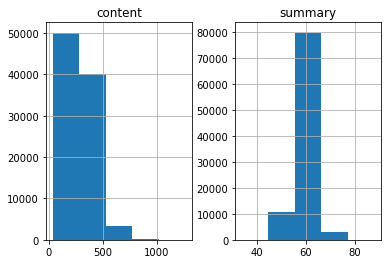

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_words_distribution(dataset_dict):
    content_count = []
    summary_count = []

    for split in dataset_dict.keys():
        for news in dataset_dict[split]:
            content_word_count = len(news['paragraphs'].split(' '))
            summary_word_count = len(news['summary'].split(' '))
            content_count.append(content_word_count)
            summary_count.append(summary_word_count)

    average_length = pd.DataFrame() 

    average_length['content'] = content_count
    average_length['summary'] = summary_count

    average_length.hist(bins = 5)
    plt.show()
    return average_length

average_length = visualize_words_distribution(indosum)          

In [12]:
def count_words_length_percentage(max_len, length_list):
    cnt = 0
    for length in length_list:
        if length <= max_len:
            cnt = cnt + 1
    return cnt / len(length_list)

max_len_content = 600
max_len_summary = 65

print(count_words_length_percentage(max_len_content, average_length['content']))
print(count_words_length_percentage(max_len_summary, average_length['summary']))

0.9818791946308725
0.944710770214126


In [13]:
indosum_new = {
    'train': [],
    'dev': [],
    'test': []
}

for split in indosum_new.keys():
    for news in indosum[split]:
        content_len = len(news['paragraphs'].split(' '))
        summary_len = len(news['summary'].split(' '))
        if (content_len <= max_len_content) and (summary_len <= max_len_summary):
            indosum_new[split].append(news)

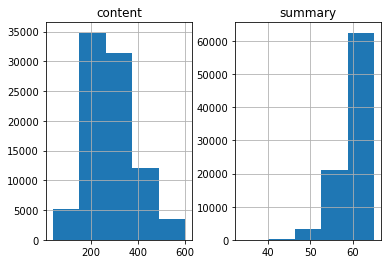

In [14]:
average_length_new = visualize_words_distribution(indosum_new)

##Split Train, Dev, Test

In [15]:
X = {
    'train': [],
     'dev': [],
     'test': []
}
for split in indosum_new.keys():
    for news in indosum_new[split]:
        X[split].append(news['paragraphs'])

y = {
    'train': [],
     'dev': [],
     'test': []
}
for split in indosum_new.keys():
    for news in indosum_new[split]:
        y[split].append(news['summary'])

In [16]:
X_train, X_dev, X_test = X['train'], X['dev'], X['test']
y_train, y_dev, y_test = y['train'], y['dev'], y['test']

##(Experimental) Word Embedding

In [17]:
#!pip install fasttext

In [18]:
#import fasttext
#import fasttext.util
 
#fasttext.util.download_model('id', if_exists='ignore')

In [19]:
#ft = fasttext.load_model("cc.id.300.bin")
#ft.get_dimension()

In [20]:
#fasttext.util.reduce_model(ft, 100)
#ft.get_dimension()

#Tokenization

In [21]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(np.array(X_train))

In [22]:
def count_rare_words(threshold, tokenizer):
    cnt = 0
    tot_cnt = 0

    for key, value in tokenizer.word_counts.items():
        tot_cnt = tot_cnt + 1
        if value < threshold:
            cnt = cnt + 1
    
    print('Threshold: {}'.format(threshold))
    print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

    return cnt, tot_cnt

cnt, tot_cnt = count_rare_words(10, x_tokenizer)

Threshold: 10
% of rare words in vocabulary:  54.2548022094626


In [23]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(np.array(X_train))

# Convert text sequences to integer sequences 
x_train_seq = x_tokenizer.texts_to_sequences(X_train) 
x_dev_seq = x_tokenizer.texts_to_sequences(X_dev)
x_test_seq = x_tokenizer.texts_to_sequences(X_test)

# Pad zero upto maximum length
x_train = pad_sequences(x_train_seq,  maxlen=max_len_content, padding='post')
x_dev = pad_sequences(x_dev_seq, maxlen=max_len_content, padding='post')
x_test = pad_sequences(x_test_seq,  maxlen=max_len_content, padding='post')

# Size of vocabulary (+1 for padding token)
x_vocab = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_vocab))

Size of vocabulary in X = 46130


In [24]:
# Prepare a tokenizer on test data
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(np.array(y_train))

cnt_test, tot_cnt_test = count_rare_words(10, y_tokenizer)

Threshold: 10
% of rare words in vocabulary:  56.45501551189245


In [25]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words = tot_cnt_test - cnt_test) 
y_tokenizer.fit_on_texts(np.array(y_train))

# Convert text sequences to integer sequences 
y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_dev_seq = y_tokenizer.texts_to_sequences(y_dev)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

# Pad zero upto maximum length
y_train = pad_sequences(y_train_seq,  maxlen=max_len_summary, padding='post')
y_dev = pad_sequences(y_dev_seq, maxlen=max_len_summary, padding='post')
y_test = pad_sequences(y_test_seq,  maxlen=max_len_summary, padding='post')

# Size of vocabulary (+1 for padding token)
y_vocab = y_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(y_vocab))

Size of vocabulary in X = 21055


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
latent_dim = 300
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_len_content, ))

# Embedding layer
enc_emb = Embedding(x_vocab, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_vocab, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

2022-06-04 14:39:43.992931: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-06-04 14:39:43.993038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: instance-machine-learning
2022-06-04 14:39:43.993052: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: instance-machine-learning
2022-06-04 14:39:43.994113: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-06-04 14:39:43.994187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-06-04 14:39:43.994195: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2022-06-04 14:39:43.996527: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instr

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 600, 300)     13839000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 600, 300),   721200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [31]:
history = model.fit(
    [x_train, y_train[:, :-1]],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_dev, y_dev[:, :-1]],
                     y_dev.reshape(y_dev.shape[0], y_dev.shape[1], 1)[:, 1:]),
    )

Epoch 1/50


2022-06-04 14:42:47.762884: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158935200 exceeds 10% of free system memory.
2022-06-04 14:42:50.496994: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at list_kernels.h:220 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[600,128,300] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[600,128,300] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node TensorArrayV2Stack/TensorListStack}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[model/lstm/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11160]

##Save Model

In [ ]:
model.save('baseline_1a')  

In [ ]:
!zip -r /content/baseline_1a.zip /content/baseline_1a/

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_len_content, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_len_summary - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
for i, news in enumerate(x_test):
    if i == 10:
        break
    print ('Review:', seq2text(news))
    print ('Original summary:', seq2summary(y_test[i]))
    print ('Predicted summary:', decode_sequence(news.reshape(1,
           max_len_content)))
    print ('\n')